In [2]:
import xgboost as xgb
import shap
import numpy as np
import pandas as pd


In [3]:
def prepare_data(data, train_start='2017-03-21', test_start='2023-01-01', test_end='2023-03-01', target='F380 M2/M3'):
     # load data
    data.pricing_date = pd.to_datetime(data.pricing_date)
    data.set_index('pricing_date', inplace=True)
    print('data @83:', data)
    
    # slice the dataset
    # data = data[data.index < non_consecutive_days(data[[target]])]
    data.interpolate(method='linear', inplace=True)
    
    data = data[(data.index >= train_start) & (data.index <= test_end)]
    data[target] = data[target].fillna(0)
    data.dropna(inplace=True)
    
    target_df = data[[target]]
    data.drop(columns=target, inplace=True)
    
    data = add_time_features(data)
    columns = drop_low_variance(data, test_start, test_end).tolist()
    columns += ['rolling_target5']
    
    # add rolling target
    data['rolling_target5'] = target_df.rolling(5).mean()
    data.dropna(inplace=True)
    
    return data[columns], target_df
    


def add_time_features(data):
    if 'year_sin' not in data.columns:
        data['year_sin'] = np.sin(data.index.year / data.index.year.max() * 2 * np.pi)

    if 'month_sin' not in data.columns:
        data['month_sin'] = np.sin(data.index.month / data.index.month.max() * 2 * np.pi)

    if 'day_sin' not in data.columns:
        data['day_sin'] = np.sin(data.index.day / data.index.day.max() * 2 * np.pi)

    if 'dow_sin' not in data.columns:
        data['dow_sin'] = np.sin(data.index.dayofweek / data.index.dayofweek.max() * 2 * np.pi)

    return data


def drop_low_variance(data, test_start, test_end, var=0.2):
    # remove rows after test start
    data = data[(data.index > '2017-03-21') & (data.index < test_start)]

    # check the length of prediction dates
    if len(data[(data.index >= test_start) & (data.index < test_end)]) < 100:
        return data.columns[data.var() > var]

    return data[['_rgp_01_sz_3', '_rgp_02_sz_3', '_rgp_03_sz_3', '_rgp_04_sz_3', '_rgp_05_sz_3',
                 'BPSG', 'COASTAL', 'GUNVORSG', 'HL', 'MERCURIASG', 'P66SG', 'PETROCHINA',
                 'SIETCO', 'TOTALSG', 'TRAFI', 'VITOLSG']].columns

In [81]:
results_with_ma = pd.read_csv('experiments/2024-01-11/results-for-2023-01-01-2023-03-01.csv')
results_wo_ma = pd.read_csv('experiments/2024-01-23/results-for-2023-01-01-2023-03-01.csv')

orig_data = pd.read_csv('data/data_2024-01-23.csv')
orig_data, target = prepare_data(orig_data)

TARGET_VALS = target.copy()
orig_data


data @83:               ALVARI  ARAMCOSG  ARAMCOTF  ARCENERGY  BBEN      BPSG  \
pricing_date                                                          
2017-01-10       0.0       0.0       0.0        0.0   0.0  0.000000   
2017-01-11       0.0       0.0       0.0        0.0   0.0  0.000000   
2017-01-12       0.0       0.0       0.0        0.0   0.0  0.000000   
2017-01-13       0.0       0.0       0.0        0.0   0.0  0.000000   
2017-01-16       0.0       0.0       0.0        0.0   0.0  0.000000   
...              ...       ...       ...        ...   ...       ...   
2024-02-16       0.0       0.0       0.0        0.0   0.0  1.333333   
2024-02-19       0.0       0.0       0.0        0.0   0.0  0.000000   
2024-02-20       0.0       0.0       0.0        0.0   0.0  0.000000   
2024-02-21       0.0       0.0       0.0        0.0   0.0  0.000000   
2024-02-22       0.0       0.0       0.0        0.0   0.0  0.000000   

              BRIGHTOILSG  BUYER1  BUYER2  CAOSG  ...  _rgp_03_sz_

C:\Users\dinar\AppData\Local\Temp\ipykernel_17660\2296070279.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\dinar\AppData\Local\Temp\ipykernel_17660\2296070279.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\dinar\AppData\Local\Temp\ipykernel_17660\2296070279.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\dinar\AppData\Local\Temp\ipyker

ALVARI  ARAMCOSG  ARAMCOTF  ARCENERGY  BBEN       BPSG  \
pricing_date                                                           
2017-03-27       0.0       0.0       0.0        0.0   0.0  10.390244   
2017-03-28       0.0       0.0       0.0        0.0   0.0   9.328589   
2017-03-29       0.0       0.0       0.0        0.0   0.0   9.328589   
2017-03-30       0.0       0.0       0.0        0.0   0.0   6.643773   
2017-03-31       0.0       0.0       0.0        0.0   0.0   9.359076   
...              ...       ...       ...        ...   ...        ...   
2023-02-23       0.0       0.0       0.0        0.0   0.0   3.915344   
2023-02-24       0.0       0.0       0.0        0.0   0.0   4.285714   
2023-02-27       0.0       0.0       0.0        0.0   0.0   4.430556   
2023-02-28       0.0       0.0       0.0        0.0   0.0   4.327044   
2023-03-01       0.0       0.0       0.0        0.0   0.0   3.664228   

              BRIGHTOILSG  BUYER1  BUYER2     CAOSG  ...  _rgp_06_sz_3  \
pricing_date                                         ...                 
2017-03-27            0.0     0.0     0.0  9.253605  ...   1673.333333   
2017-03-28            0.0     0.0     0.0  7.814089  ...   1673.333333   
2017-03-29            0.0     0.0     0.0  7.291213  ...   1673.333333   
2017-03-30            0.0     0.0     0.0  7.291213  ...   1673.333333   
2017-03-31            0.0     0.0     0.0  6.240409  ...   1040.000000   
...                   ...     ...     ...       ...  ...           ...   
2023-02-23            0.0     0.0     0.0  0.000000  ...   -300.000000   
2023-02-24            0.0     0.0     0.0  0.000000  ...   -545.000000   
2023-02-27            0.0     0.0     0.0  0.000000  ...   -695.000000   
2023-02-28            0.0     0.0     0.0  0.000000  ...   -470.000000   
2023-03-01            0.0     0.0     0.0  0.000000  ...   -388.333333   

              _rgp_07_sz_3  _rgp_08_sz_3  _rgp_09_sz_3  _rgp_10_sz_3  \
pricing_date                                                           
2017-03-27     3636.666667      0.000000           0.0           0.0   
2017-03-28     3586.666667      0.000000           0.0           0.0   
2017-03-29     3346.666667      0.000000           0.0           0.0   
2017-03-30     3346.666667      0.000000           0.0           0.0   
2017-03-31     2440.000000      0.000000           0.0           0.0   
...                    ...           ...           ...           ...   
2023-02-23      -70.000000    -81.666667           0.0           0.0   
2023-02-24     -340.000000   -491.666667           0.0           0.0   
2023-02-27     -123.333333   -970.000000           0.0           0.0   
2023-02-28     -123.333333   -792.500000           0.0           0.0   
2023-03-01      146.666667   -682.500000           0.0           0.0   

              _rgp_11_sz_3  month_sin       day_sin       dow_sin  \
pricing_date                                                        
2017-03-27             0.0   1.000000 -7.247928e-01  0.000000e+00   
2017-03-28             0.0   1.000000 -5.712682e-01  1.000000e+00   
2017-03-29             0.0   1.000000 -3.943559e-01  1.224647e-16   
2017-03-30             0.0   1.000000 -2.012985e-01 -1.000000e+00   
2017-03-31             0.0   1.000000 -2.449294e-16 -2.449294e-16   
...                    ...        ...           ...           ...   
2023-02-23             0.0   0.866025 -9.987165e-01 -1.000000e+00   
2023-02-24             0.0   0.866025 -9.884683e-01 -2.449294e-16   
2023-02-27             0.0   0.866025 -7.247928e-01  0.000000e+00   
2023-02-28             0.0   0.866025 -5.712682e-01  1.000000e+00   
2023-03-01             0.0   1.000000  2.012985e-01  1.224647e-16   

              rolling_target5  
pricing_date                   
2017-03-27              -0.06  
2017-03-28              -0.04  
2017-03-29              -0.09  
2017-03-30              -0.13  
2017-03-31              -0.16  
...                       ...  
2023-02-23             

In [72]:
target

F380 M2/M3
pricing_date            
2017-03-21         -0.35
2017-03-22          0.10
2017-03-23          0.10
2017-03-24         -0.10
2017-03-27         -0.05
...                  ...
2023-02-23          2.40
2023-02-24          2.30
2023-02-27          2.30
2023-02-28          2.25
2023-03-01          3.50

[1552 rows x 1 columns]

In [5]:
model_without_ma = xgb.Booster()
model_without_ma.load_model('experiments/models/train_without_ma.model')

model_with_ma = xgb.Booster()
model_with_ma.load_model('experiments/models/train-until-2023_variance=0.2_col_length=68.model')

In [6]:
orig_wo_ma = orig_data.copy().drop(columns='rolling_target5')
orig_with_ma = orig_data.copy()

print(orig_wo_ma.shape)
print(orig_with_ma.shape)

(1548, 68)
(1548, 69)


In [7]:
orig_wo_ma = orig_wo_ma[orig_wo_ma.index <= '2023-03-01']
orig_with_ma = orig_with_ma[orig_with_ma.index <= '2023-03-01']

In [8]:
from sklearn.model_selection import train_test_split

def f_wo_ma(x):
    return model_without_ma.predict(x)


def f_with_ma(x):
    return model_with_ma.predict(x)


[03:20:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


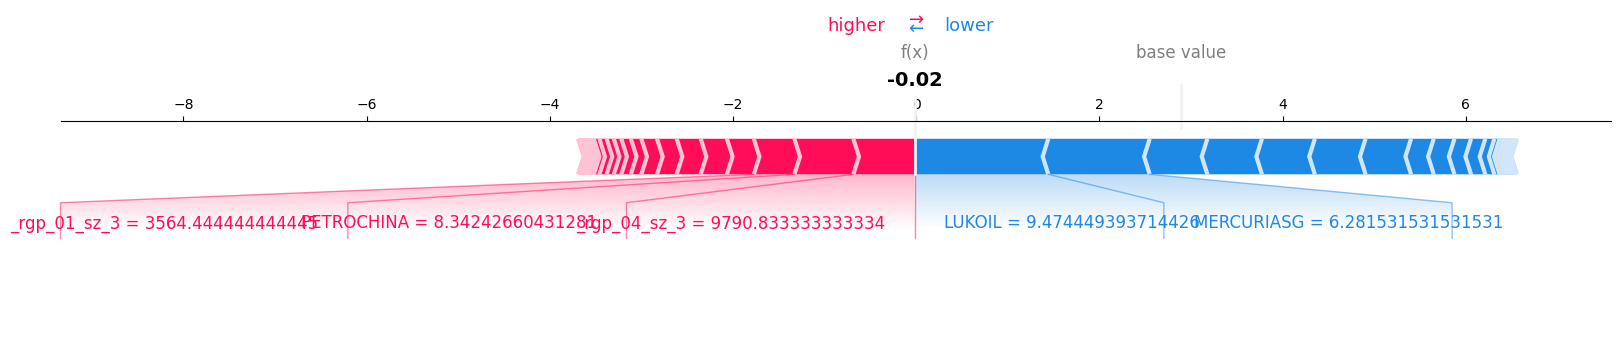

In [9]:
# WITHOUT ROLLING
import matplotlib

explainer = shap.TreeExplainer(model_without_ma)
shap_values = explainer.shap_values(orig_wo_ma)
shap.force_plot(explainer.expected_value, shap_values[0, :], orig_wo_ma.iloc[0, :], matplotlib=matplotlib)


In [10]:
from IPython.core.display import display, HTML

plot = shap.force_plot(explainer.expected_value, shap_values[:1000, :], orig_wo_ma.iloc[:1000, :], matplotlib=False)
shap_html = f"{shap.getjs()}{plot.html()}"
display(HTML(shap_html))

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


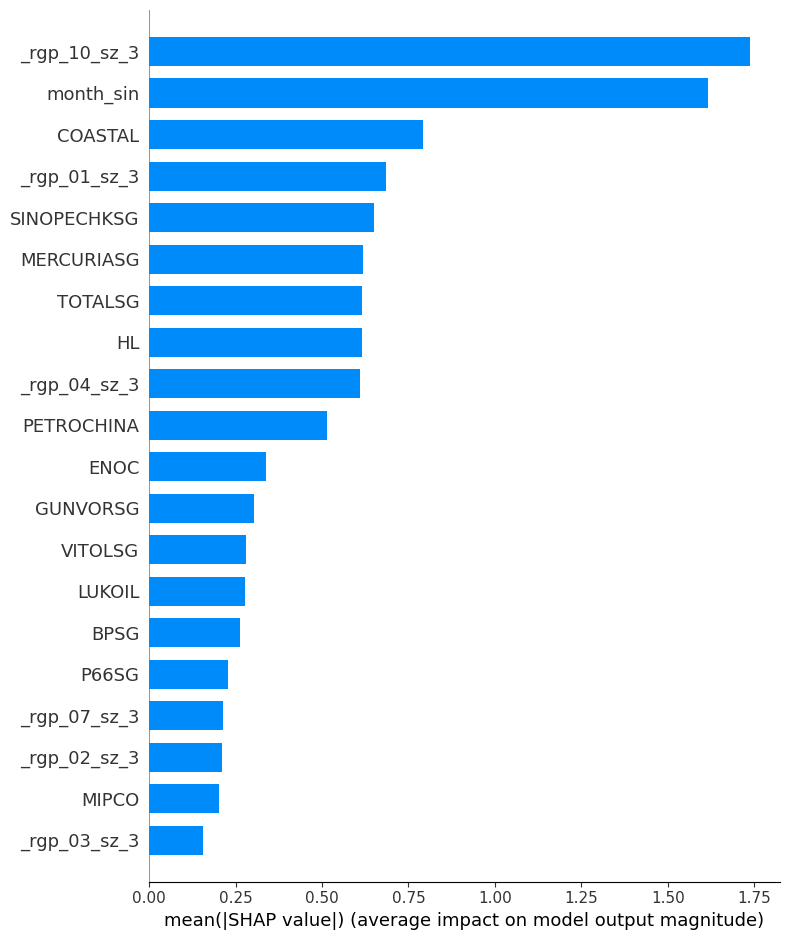

In [11]:
shap.summary_plot(shap_values, orig_wo_ma, plot_type="bar")

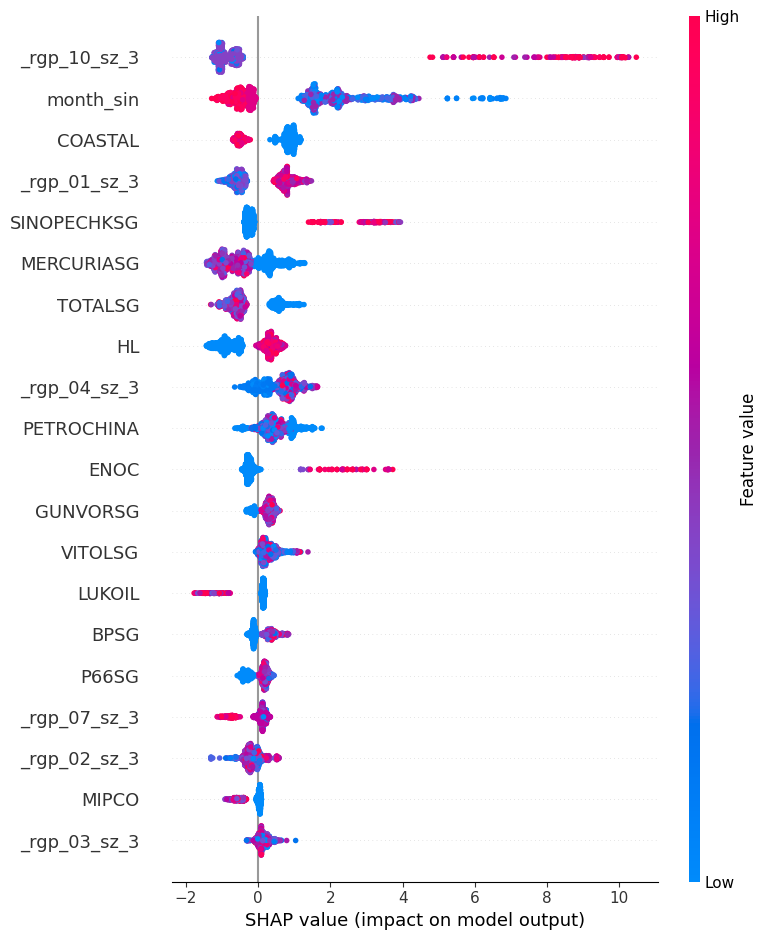

In [12]:
shap.summary_plot(shap_values, orig_wo_ma)

[03:21:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


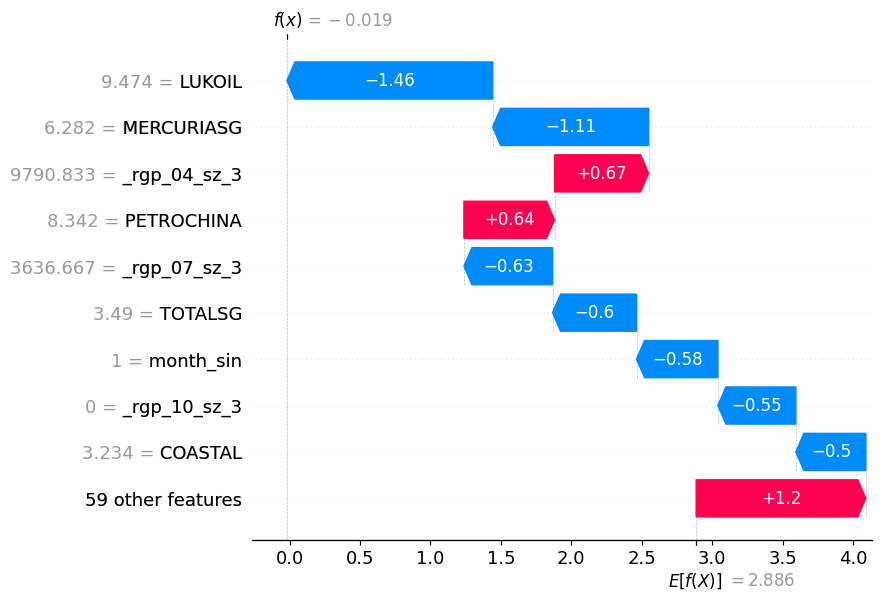

In [13]:
explainer = shap.Explainer(model_without_ma)
shap_values = explainer(orig_wo_ma)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [14]:
shap_values[0]

.values =
array([ 5.9559196e-03, -2.8809518e-02, -1.4129705e-03,  0.0000000e+00,
        2.5369674e-03,  1.7144595e-01, -2.7196913e-03, -8.3583901e-03,
        0.0000000e+00, -3.6964141e-02, -5.7058115e-02, -2.0170636e-02,
       -2.7735026e-03, -4.9664351e-01,  0.0000000e+00, -2.2608173e-01,
        6.0039065e-03, -2.4743199e-01,  0.0000000e+00,  0.0000000e+00,
        2.9341358e-01,  2.6212138e-01, -3.7272233e-03,  0.0000000e+00,
       -4.3954504e-05,  0.0000000e+00, -1.4605764e+00,  2.6590033e-02,
        1.1257439e-02,  1.8333932e-02, -1.1072695e+00,  1.6919099e-02,
        8.2581583e-03,  1.0456492e-01,  1.1098889e-02,  6.4344919e-01,
        3.9373692e-03,  1.7947700e-02, -4.4349268e-02,  6.0637407e-02,
       -1.3890465e-03,  7.8846097e-02,  0.0000000e+00,  9.5595596e-03,
       -1.5572892e-01,  5.3683965e-05, -1.8124062e-01, -8.6170144e-04,
       -5.9607136e-01,  7.8811288e-02,  0.0000000e+00,  2.8625661e-01,
        4.5876874e-04,  5.5451281e-03,  4.4315672e-01, -9.9301152e-

In [17]:
import plotly.express as px
import plotly.graph_objects as go

def get_colors(values):
    return ['green' if v >= 0 else 'red' for v in values]

features = pd.DataFrame({'column': orig_wo_ma.columns, 'value': shap_values[0].values})
print(features)
features['abs_value'] = features['value'].abs()
sort = features.sort_values('abs_value', ascending=False).head(10)[['column', 'value']]

fig = go.Figure(go.Bar(x=sort['value'], y=sort['column'], orientation='h', marker=dict(color=get_colors(sort.value.tolist()))))
fig.update_xaxes(range=[-5, 5])
fig.show()



# fig = go.Figure(go.Waterfall(name = "2018", orientation = "h", y=sort['column'], x=sort['value'], 
#                              connector_visible=False, measure=['absolute'] * 10))

# fig.update_layout(title = "Profit and loss statement 2018")
# fig.update_xaxes(range=[-5, 5])
# fig.show()

          column     value
0         ALVARI  0.005956
1       ARAMCOSG -0.028810
2       ARAMCOTF -0.001413
3      ARCENERGY  0.000000
4           BBEN  0.002537
..           ...       ...
63  _rgp_10_sz_3 -0.553533
64  _rgp_11_sz_3  0.000000
65     month_sin -0.577717
66       day_sin -0.001677
67       dow_sin  0.000000

[68 rows x 2 columns]


In [16]:
import plotly.graph_objects as go

def create_waterfall(df, model, idx=0, shap_values=None):
    if shap_values is None:
        explainer = shap.Explainer(model)
        shap_values = explainer(df)
    
    features = pd.DataFrame({'column': df.columns, 'value': shap_values[idx].values})
    features['abs_value'] = features['value'].abs()
    sort = features.sort_values('abs_value', ascending=False).head(10)[['column', 'value']]

    fig = go.Figure(go.Bar(x=sort['value'], y=sort['column'], orientation='h', marker=dict(color=get_colors(sort.value.tolist()))))
    fig.update_xaxes(range=[-5, 5])
    return fig
    
    
    
    # fig = go.Figure(go.Waterfall(
    #     name='Waterfall graph', orientation='h', 
    # ))


# fig = go.Figure(go.Waterfall(
#     name = "2018", orientation = "h", measure = ["relative", "relative", "relative", "relative", "total", "relative",
#                                               "relative", "relative", "relative", "total", "relative", "relative", "total", "relative", "total"],
#     y = ["Sales", "Consulting", "Maintenance", "Other revenue", "Net revenue", "Purchases", "Material expenses",
#        "Personnel expenses", "Other expenses", "Operating profit", "Investment income", "Financial income",
#        "Profit before tax", "Income tax (15%)", "Profit after tax"],
#     x = [375, 128, 78, 27, None, -327, -12, -78, -12, None, 32, 89, None, -45, None],
#     connector = {"mode":"between", "line":{"width":4, "color":"rgb(0, 0, 0)", "dash":"solid"}}
# ))

# fig.update_layout(title = "Profit and loss statement 2018")

# fig.show()

In [18]:
import os
import re
import pandas as pd
import panel as pn
import param
import os
import holoviews as hv

import pandas as pd
import plotly.graph_objects as go

# perspective packages
import pickle
from pathlib import Path
import datetime as dt

In [19]:
pn.config.js_files["jquery"]="https://code.jquery.com/jquery-1.12.4.min.js"
pn.config.js_files["sparkline"]="https://cdnjs.cloudflare.com/ajax/libs/jquery-sparklines/2.1.2/jquery.sparkline.min.js"

pn.extension('tabulator', 'plotly', 'ipywidgets', 'perspective',  css_files=[pn.io.resources.CSS_URLS['font-awesome']], sizing_mode='stretch_width', omms='ipywidgets')

pn.config.js_files["sparkline_to_tabulator"]="https://cdn.jsdelivr.net/gh/MarcSkovMadsen/awesome-panel-assets@master/js/add_spark_lines_to_tabulator.min.js"


In [20]:
def custom_pnl_10(y_pred, y_true):
    nth = len(y_pred)

    thresh = 0.2
    
    try:
        diff = y_pred[-1] - y_pred[0]
    except IndexError:
        diff = y_pred[-1] - y_pred[0]

    direction = 1 if diff > thresh else (-1 if diff < thresh else 0)
    pnl = diff * direction

    return 'pnl', pnl

In [21]:
import numpy as np


def get_preds(preds, date):
    preds_df = preds.copy()
    preds_df = preds_df[preds_df['forecast_date'] == date]

    if 'index' in preds_df.columns:
        idx = np.unique(preds_df['index'], return_index=True)[1]
    else:
        idx = np.unique(preds_df.index, return_index=True)[1]
    return preds_df.iloc[idx]

In [22]:
preds_df = pd.read_csv('experiments/2024-01-23/results-for-2023-01-01-2023-03-01.csv', index_col=0)
preds_df.set_index('pricing_date', inplace=True)
preds_df.index = pd.to_datetime(preds_df.index)
preds_df = preds_df.drop(columns='target')
preds_df

preds forecast_date
pricing_date                        
2023-01-02    1.132187    2023-01-02
2023-01-03    2.082799    2023-01-02
2023-01-04    1.660509    2023-01-02
2023-01-05    2.345542    2023-01-02
2023-01-06    1.264507    2023-01-02
...                ...           ...
2023-02-23    0.938970    2023-02-16
2023-02-24    2.047681    2023-02-16
2023-02-27    1.765619    2023-02-16
2023-02-28    1.809530    2023-02-16
2023-03-01    1.199825    2023-02-16

[340 rows x 2 columns]

ALVARI  ARAMCOSG  ARAMCOTF  ARCENERGY  BBEN       BPSG  \
pricing_date                                                           
2017-03-27       0.0       0.0       0.0        0.0   0.0  10.390244   
2017-03-28       0.0       0.0       0.0        0.0   0.0   9.328589   
2017-03-29       0.0       0.0       0.0        0.0   0.0   9.328589   
2017-03-30       0.0       0.0       0.0        0.0   0.0   6.643773   
2017-03-31       0.0       0.0       0.0        0.0   0.0   9.359076   
...              ...       ...       ...        ...   ...        ...   
2023-02-23       0.0       0.0       0.0        0.0   0.0   3.915344   
2023-02-24       0.0       0.0       0.0        0.0   0.0   4.285714   
2023-02-27       0.0       0.0       0.0        0.0   0.0   4.430556   
2023-02-28       0.0       0.0       0.0        0.0   0.0   4.327044   
2023-03-01       0.0       0.0       0.0        0.0   0.0   3.664228   

              BRIGHTOILSG  BUYER1  BUYER2     CAOSG  ...  _rgp_06_sz_3  \
pricing_date                                         ...                 
2017-03-27            0.0     0.0     0.0  9.253605  ...   1673.333333   
2017-03-28            0.0     0.0     0.0  7.814089  ...   1673.333333   
2017-03-29            0.0     0.0     0.0  7.291213  ...   1673.333333   
2017-03-30            0.0     0.0     0.0  7.291213  ...   1673.333333   
2017-03-31            0.0     0.0     0.0  6.240409  ...   1040.000000   
...                   ...     ...     ...       ...  ...           ...   
2023-02-23            0.0     0.0     0.0  0.000000  ...   -300.000000   
2023-02-24            0.0     0.0     0.0  0.000000  ...   -545.000000   
2023-02-27            0.0     0.0     0.0  0.000000  ...   -695.000000   
2023-02-28            0.0     0.0     0.0  0.000000  ...   -470.000000   
2023-03-01            0.0     0.0     0.0  0.000000  ...   -388.333333   

              _rgp_07_sz_3  _rgp_08_sz_3  _rgp_09_sz_3  _rgp_10_sz_3  \
pricing_date                                                           
2017-03-27     3636.666667      0.000000           0.0           0.0   
2017-03-28     3586.666667      0.000000           0.0           0.0   
2017-03-29     3346.666667      0.000000           0.0           0.0   
2017-03-30     3346.666667      0.000000           0.0           0.0   
2017-03-31     2440.000000      0.000000           0.0           0.0   
...                    ...           ...           ...           ...   
2023-02-23      -70.000000    -81.666667           0.0           0.0   
2023-02-24     -340.000000   -491.666667           0.0           0.0   
2023-02-27     -123.333333   -970.000000           0.0           0.0   
2023-02-28     -123.333333   -792.500000           0.0           0.0   
2023-03-01      146.666667   -682.500000           0.0           0.0   

              _rgp_11_sz_3  month_sin       day_sin       dow_sin  \
pricing_date                                                        
2017-03-27             0.0   1.000000 -7.247928e-01  0.000000e+00   
2017-03-28             0.0   1.000000 -5.712682e-01  1.000000e+00   
2017-03-29             0.0   1.000000 -3.943559e-01  1.224647e-16   
2017-03-30             0.0   1.000000 -2.012985e-01 -1.000000e+00   
2017-03-31             0.0   1.000000 -2.449294e-16 -2.449294e-16   
...                    ...        ...           ...           ...   
2023-02-23             0.0   0.866025 -9.987165e-01 -1.000000e+00   
2023-02-24             0.0   0.866025 -9.884683e-01 -2.449294e-16   
2023-02-27             0.0   0.866025 -7.247928e-01  0.000000e+00   
2023-02-28             0.0   0.866025 -5.712682e-01  1.000000e+00   
2023-03-01             0.0   1.000000  2.012985e-01  1.224647e-16   

              rolling_target5  
pricing_date                   
2017-03-27              -0.06  
2017-03-28              -0.04  
2017-03-29              -0.09  
2017-03-30              -0.13  
2017-03-31              -0.16  
...                       ...  
2023-02-23             

In [91]:
import param
import numpy as np
import panel as pn
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import holoviews as hv
import hvplot.pandas
# from datetime import strptime

SELECTED_RANGE = None

forecast_dates = sorted(list(preds_df['forecast_date'].unique()))

def create_waterfall(df, model, idx=0, shap_values=None):
    if shap_values is None:
        explainer = shap.Explainer(model)
        shap_values = explainer(df)
    
    # df = df[(df.index >= '2023-01-01') & (df.index <= '2023-03-01')]
    print(len(df), len(shap_values))
    print(len(shap_values[idx].values))
    print(shap_values[idx].values)
    print(len(df.columns.tolist()))
    
    features = pd.DataFrame({'column': df.drop(columns='F380 M2/M3').columns, 'value': shap_values[idx].values})
    features['abs_value'] = features['value'].abs()
    sort = features.sort_values('abs_value', ascending=False).head(10)[['column', 'value']]

    fig = go.Figure(go.Bar(x=sort['value'], y=sort['column'], orientation='h', marker=dict(color=get_colors(sort.value.tolist()))))
    fig.update_xaxes(range=[-5, 5])
    return fig


class Model(param.Parameterized):
    format_date = lambda x: [int(y) for y in x.split('-')]
    start_date, end_date = dt.datetime(*format_date(forecast_dates[0])), dt.datetime(*format_date(forecast_dates[-1]))
    values = (start_date, end_date)
    period = param.DateRange(default=values, bounds=(start_date, end_date))

def select_available_dates(values):
    available = []

    for option in checkboxes.values:
        opt = datetime(*[int(x) for x in option.split('-')])
        if values[0] <= opt <= values[1]:
            available.append(option)
            
    return available

def out(value):
    checkboxes.value = select_available_dates(value)
    
todate = lambda x: datetime.strptime(x, '%Y-%m-%d')

model = Model()
checkboxes = pn.widgets.CheckBoxGroup(name='Checkbox Group', value=[forecast_dates[0]], options=forecast_dates, inline=False, margin=(20, 10, 10, 10))

target2 = target.copy()
orig_wo_ma['F380 M2/M3'] = target2[4:]

select = get_preds(preds_df, forecast_dates[0])
target4 = orig_wo_ma[(orig_wo_ma.index >= select.index.min()) & (orig_wo_ma.index <= select.index.max())]['F380 M2/M3']
select['target'] = target4.values
TARGETS = {}
date_picker = pn.widgets.DatePicker(value=preds_df.index.min().date(), start=preds_df.index.min().date(), end=preds_df.index.max().date())

def create_pnl(df_copy):
    results = {}

    uniq = df_copy.forecast_date.unique()

    for date in uniq:
        d = df_copy[df_copy.forecast_date == date]
        res = custom_pnl_10(d.preds.values, d.target.values)

        if any(TARGETS[date].target.isna().tolist()):
            results[date] = 'unknown'
        else:
            results[date] = res[1]

    return pd.DataFrame(results.values(), index=results.keys(), columns=['pnl'])


@pn.depends(date_picker.param.value)
def update_pnl_df(sel):
    slices = orig_wo_ma[(orig_wo_ma.index >= SELECTED_RANGE.pricing_date.min()) & (orig_wo_ma.index <= SELECTED_RANGE.pricing_date.max())]
    idx = len(orig_wo_ma[orig_wo_ma.index < SELECTED_RANGE.pricing_date.max()]) - 1
    
    print(idx)
    return create_waterfall(orig_wo_ma, model_without_ma, idx=idx, shap_values=shap_values)
    

@pn.depends(date_picker.param.value)
def update_plot(selected):
    global SELECTED_RANGE, dataframe
    
    print(selected, type(selected))
    print(str(selected))
    
    sel = preds_df['forecast_date'].apply(lambda x: x in [str(selected)])
    selected_range = preds_df[sel]
    selected_range.reset_index(inplace=True)
    print(selected_range)
    SELECTED_RANGE = selected_range
    
    SELECTED_RANGE['target'] = None

    fig = go.Figure()
    
    for unique_date in selected_range.forecast_date.unique():
        select = get_preds(selected_range, unique_date)
        print(select)
        fig.add_trace(go.Scatter(x=select.pricing_date, y=select.preds, name='Preds:' + unique_date, connectgaps=False))

        print('Min date:', select.pricing_date.min())

        # get real target values 
        target2 = TARGET_VALS.copy()
        target3 = target2[(target2.index >= select.pricing_date.min())][:10]
        
        print('Created target3:', target3)
        
        fig.add_trace(go.Scatter(x=target3.index, y=target3['F380 M2/M3'].values, name='Hist:' + unique_date, connectgaps=False, line=dict(color='red')))

        # target3.index = pd.to_datetime(target3.index)
        # target3.interpolate(method='linear', inplace=True)

        # # print(target3)
        # target3 = pd.DataFrame({'index': target3.index, 'target': target3['F380 M2/M3'].values})
        # print('FINAL TARGET3:', target3)
        # target3['index'] = pd.to_datetime(target3['index'])

        TARGETS[unique_date] = target3

    return fig


sidebar = pn.Column(date_picker)

widget = pn.WidgetBox(pn.Row(pn.Column(update_plot, width=1000), pn.Column(update_pnl_df, width=500)), date_picker, height=700)
main = pn.template.FastGridTemplate(main=widget, main_max_width='100%')
main.show()

2023-01-02 <class 'datetime.date'>
2023-01-02
  pricing_date     preds forecast_date
0   2023-01-02  1.132187    2023-01-02
1   2023-01-03  2.082799    2023-01-02
2   2023-01-04  1.660509    2023-01-02
3   2023-01-05  2.345542    2023-01-02
4   2023-01-06  1.264507    2023-01-02
5   2023-01-09  3.680506    2023-01-02
6   2023-01-10  3.404079    2023-01-02
7   2023-01-11  3.929311    2023-01-02
8   2023-01-12  1.110283    2023-01-02
9   2023-01-13  0.807344    2023-01-02
  pricing_date     preds forecast_date target
0   2023-01-02  1.132187    2023-01-02   None
1   2023-01-03  2.082799    2023-01-02   None
2   2023-01-04  1.660509    2023-01-02   None
3   2023-01-05  2.345542    2023-01-02   None
4   2023-01-06  1.264507    2023-01-02   None
5   2023-01-09  3.680506    2023-01-02   None
6   2023-01-10  3.404079    2023-01-02   None
7   2023-01-11  3.929311    2023-01-02   None
8   2023-01-12  1.110283    2023-01-02   None
9   2023-01-13  0.807344    2023-01-02   None
Min date: 2023-01-0

C:\Users\dinar\AppData\Local\Temp\ipykernel_17660\3833105759.py:107: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-01-21 <class 'datetime.date'>
2023-01-21
Empty DataFrame
Columns: [pricing_date, preds, forecast_date]
Index: []
-1
1548 1548
68
[-4.81557660e-03 -2.97233462e-02 -2.39434093e-03  0.00000000e+00
  8.94310942e-04  3.88972133e-01 -4.98579117e-03 -1.94216743e-02
  0.00000000e+00  1.70264412e-02  6.39682356e-03  1.26562244e-03
 -1.94666162e-03  7.36184955e-01  0.00000000e+00 -3.10696274e-01
 -2.44963728e-03  1.59057245e-01  0.00000000e+00  0.00000000e+00
  2.27813810e-01 -8.91096532e-01  1.70459121e-01  0.00000000e+00
 -8.74395628e-05  0.00000000e+00  1.31508827e-01  1.14084594e-02
 -1.84178308e-01 -2.40507081e-01 -6.95415884e-02  1.54811293e-02
 -2.30523758e-02  1.71076357e-01  5.29686920e-03  7.28147998e-02
  2.37393659e-03  3.75396945e-02  2.40859622e-03  6.06341809e-02
  7.66911078e-04  7.48383701e-02  0.00000000e+00  9.27026290e-03
  1.75289583e+00  9.10874864e-04 -7.54183754e-02 -1.21360598e-03
  4.17442113e-01 -2.51301974e-01  0.00000000e+00  6.45697594e-01
  5.82715776e-03  2.0

C:\Users\dinar\AppData\Local\Temp\ipykernel_17660\3833105759.py:107: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2023-01-26 <class 'datetime.date'>
2023-01-26
  pricing_date     preds forecast_date
0   2023-01-26  1.910847    2023-01-26
1   2023-01-27  2.988141    2023-01-26
2   2023-01-30  1.589718    2023-01-26
3   2023-01-31  0.267007    2023-01-26
4   2023-02-01  0.165054    2023-01-26
5   2023-02-02  0.100237    2023-01-26
6   2023-02-03  0.183895    2023-01-26
7   2023-02-06  2.884224    2023-01-26
8   2023-02-07  2.144707    2023-01-26
9   2023-02-08  2.400744    2023-01-26
  pricing_date     preds forecast_date target
0   2023-01-26  1.910847    2023-01-26   None
1   2023-01-27  2.988141    2023-01-26   None
2   2023-01-30  1.589718    2023-01-26   None
3   2023-01-31  0.267007    2023-01-26   None
4   2023-02-01  0.165054    2023-01-26   None
5   2023-02-02  0.100237    2023-01-26   None
6   2023-02-03  0.183895    2023-01-26   None
7   2023-02-06  2.884224    2023-01-26   None
8   2023-02-07  2.144707    2023-01-26   None
9   2023-02-08  2.400744    2023-01-26   None
Min date: 2023-01-2

C:\Users\dinar\AppData\Local\Temp\ipykernel_17660\3833105759.py:107: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [75]:
target.values

array([ 0.5 , -0.5 , -1.  , -1.1 , -0.75, -0.75, -0.75, -1.  , -2.  ,
       -1.75])

In [58]:
preds_df['forecast_date'].apply(lambda x: x in ['2023-01-02'])

pricing_date
2023-01-02     True
2023-01-03     True
2023-01-04     True
2023-01-05     True
2023-01-06     True
              ...  
2023-02-23    False
2023-02-24    False
2023-02-27    False
2023-02-28    False
2023-03-01    False
Name: forecast_date, Length: 340, dtype: bool

In [27]:
select.index.min()

Timestamp('2023-01-02 00:00:00')

In [82]:
forecast_dates

['2023-01-02',
 '2023-01-03',
 '2023-01-04',
 '2023-01-05',
 '2023-01-06',
 '2023-01-09',
 '2023-01-10',
 '2023-01-11',
 '2023-01-12',
 '2023-01-13',
 '2023-01-16',
 '2023-01-17',
 '2023-01-18',
 '2023-01-19',
 '2023-01-20',
 '2023-01-23',
 '2023-01-24',
 '2023-01-25',
 '2023-01-26',
 '2023-01-27',
 '2023-01-30',
 '2023-01-31',
 '2023-02-01',
 '2023-02-02',
 '2023-02-03',
 '2023-02-06',
 '2023-02-07',
 '2023-02-08',
 '2023-02-09',
 '2023-02-10',
 '2023-02-13',
 '2023-02-14',
 '2023-02-15',
 '2023-02-16']

In [79]:
import param
import numpy as np
import panel as pn
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import holoviews as hv
import hvplot.pandas

SELECTED_RANGE = None

forecast_dates = sorted(list(preds_df['forecast_date'].unique()))

class Model(param.Parameterized):
    format_date = lambda x: [int(y) for y in x.split('-')]
    start_date, end_date = dt.datetime(*format_date(forecast_dates[0])), dt.datetime(*format_date(forecast_dates[-1]))
    values = (start_date, end_date)
    period = param.DateRange(default=values, bounds=(start_date, end_date))

def select_available_dates(values):
    available = []

    for option in checkboxes.values:
        opt = datetime(*[int(x) for x in option.split('-')])
        if values[0] <= opt <= values[1]:
            available.append(option)
            
    return available

def out(value):
    checkboxes.value = select_available_dates(value)

model = Model()
date_picker = pn.widgets.DatetimeRangePicker.from_param(model.param.period, enable_time=False)
checkboxes = pn.widgets.CheckBoxGroup(name='Checkbox Group', value=[forecast_dates[0]], options=forecast_dates, inline=False, margin=(20, 10, 10, 10))

target2 = target.copy()
orig_wo_ma['F380 M2/M3'] = target2[4:]

select = get_preds(preds_df, forecast_dates[0])
target = orig_wo_ma[(orig_wo_ma.index >= select.index.min()) & (orig_wo_ma.index <= select.index.max())]['F380 M2/M3']
select['target'] = target.values
TARGETS = {}

def create_pnl(df_copy):
    results = {}

    uniq = df_copy.forecast_date.unique()

    for date in uniq:
        d = df_copy[df_copy.forecast_date == date]
        res = custom_pnl_10(d.preds.values, d.target.values)

        if any(TARGETS[date].target.isna().tolist()):
            results[date] = 'unknown'
        else:
            results[date] = res[1]

    return pd.DataFrame(results.values(), index=results.keys(), columns=['pnl'])


@pn.depends(checkboxes.param.value)
def update_pnl_df(sel):
    slices = orig_wo_ma[(orig_wo_ma.index >= SELECTED_RANGE.pricing_date.min()) & (orig_wo_ma.index <= SELECTED_RANGE.pricing_date.max())]
    idx = len(orig_wo_ma[orig_wo_ma.index < SELECTED_RANGE.pricing_date.max()]) - 1
    
    return slices.hvplot.waterfall(width=800, dynamic=False)
    

@pn.depends(checkboxes.param.value)
def update_plot(selected):
    global SELECTED_RANGE, dataframe
    
    sel = preds_df['forecast_date'].apply(lambda x: x in selected)
    selected_range = preds_df[sel]
    selected_range.reset_index(inplace=True)
    print(selected_range)
    SELECTED_RANGE = selected_range
    
    SELECTED_RANGE['target'] = None

    fig = go.Figure()
    
    for unique_date in selected_range.forecast_date.unique():
        select = get_preds(selected_range, unique_date)
        fig.add_trace(go.Scatter(x=select.pricing_date, y=select.preds, name='Preds:' + unique_date, connectgaps=False))

        # get real target values 
        target = orig_wo_ma[(orig_wo_ma.index >= select.pricing_date.min()) & (orig_wo_ma.index <= select.pricing_date.max())]['F380 M2/M3']
        target.index = pd.to_datetime(target.index)
        target.interpolate(method='linear', inplace=True)
        fig.add_trace(go.Scatter(x=target.index, y=target.values, name='Hist:' + unique_date, connectgaps=False, line=dict(color='red')))

        target = pd.DataFrame({'index': target.index, 'target': target.values})
        target['index'] = pd.to_datetime(target['index'])

        TARGETS[unique_date] = target

    return fig


sidebar = pn.Column(date_picker, pn.bind(out, model.param.period), checkboxes)

widget = pn.WidgetBox(pn.Row(pn.Column(update_plot, width=1000), pn.Column(update_pnl_df, width=200)), height=700)
main = pn.template.FastGridTemplate(main=widget, sidebar=sidebar, main_max_width='100%')
main.show()

ValueError: CalendarDate parameter 'DatePicker.value' only takes date types.